In [1]:
from utils import  complete_tests
from collections import defaultdict
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
base_path = '../../dataset/synthetic/large_conserving'
complete_results = []

In [3]:
total_species = 0
correct_species = 0
uncertain_species = 0
graph_directory = '../../dataset/synthetic/large_conserving'
tested_graphs = 0
true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0
uncertain = []  # The species whose results are between bounds: store the absolute delta and the compound one
statistics_deltas = []  # Store both deltas for every specie in order to have a statistic about magnitudes
# Stores the accuracy for each PW (each experiment individually) the key is the graph number
pathways_results = defaultdict(lambda: [])

for graph in list(os.listdir(graph_directory)):

    # Stores the total number of species classified for this PW (all experiments)
    total_count_pw = 0
    correct_count_pw = 0

    # Results for each experiment: the key is the experiment number 
    # Results include: accuracy and two arrays: correct and incorrect species
    pathway_results = defaultdict(lambda: {})

    print("TESTED GRAPHS ", tested_graphs)
    tested_graphs += 1
    can_complete = False

    if graph == '.DS_Store': continue
    for experiment in list(os.listdir(os.path.join(graph_directory, graph))):

        if experiment == '.DS_Store': continue
        print('GRAPH: ', graph, ' EXPERIMENT: ', experiment, ' DIRECTORY: ', str(experiment))

        res = complete_tests.complete_tests2(
            os.path.join(graph_directory, graph, experiment, 'normal.xml'),
            os.path.join(graph_directory, graph, experiment, 'altered.xml'),
            os.path.join(graph_directory, graph, experiment, 'description'),
            []
        )
        
        # If errors happened during simulation skip that experiment
        if res['normal']['real'] == None or res['altered']['real'] == None: continue

        complete_results.append(res)

        insights, all, uncertain, d_normal, d_uncertain = complete_tests.get_insights_confidence_intervals('altered',
                                                                                                           res, 0,
                                                                                                           detailed_classification=False,
                                                                                                           threshold=0,
                                                                                                           ignore_uncertain=False)

        total_species += all  # Whole-class level
        uncertain_species += uncertain

        # Experimet-level
        total_count = 0
        correct_count = 0
        correct_species_list = []
        wrong_species_list = []

        for specie in insights.keys():

            if insights[specie][0] == 0 or insights[specie][1][1] == 0.5:
                continue

            total_count += 1
            if insights[specie][0] == insights[specie][1][0]:
                correct_count += 1
                correct_species += 1  # Whole-class level
                #correct_species_list.append(specie)
            #else:
            #wrong_species_list.append(specie)

            if insights[specie][1][0] == insights[specie][0] == 1:
                correct_species_list.append([specie, {'predicted': 1, 'actual': 1}])
                true_positives += 1
            elif insights[specie][1][0] == insights[specie][0] == -1:
                correct_species_list.append([specie, {'predicted': -1, 'actual': -1}])
                true_negatives += 1
            elif insights[specie][1][0] == 1 and insights[specie][0] == -1:
                wrong_species_list.append([specie, {'predicted': 1, 'actual': -1}])
                false_positives += 1
            elif insights[specie][1][0] == -1 and insights[specie][0] == 1:
                wrong_species_list.append([specie, {'predicted': -1, 'actual': 1}])
                false_negatives += 1

        desc_file = open(os.path.join(graph_directory, graph, experiment, 'description'), 'rb')
        desc = pickle.load(desc_file)
        desc_file.close()

        print('ALTERED REACTION: ', desc['altered'])
        print('CORRECT, TOTAL, RATIO: ', correct_count, total_count, correct_count / total_count)

        pathway_results[experiment]['ratio'] = correct_count / total_count
        pathway_results[experiment]['correct_species'] = correct_species_list
        pathway_results[experiment]['wrong_species'] = wrong_species_list
        pathway_results[experiment]['altered'] =  desc['altered']
        #pathway_scores.append(correct_count / total_count)
    #pathways_scores.append(pathway_scores)
    pathways_results[graph] = pathway_results


TESTED GRAPHS  0
GRAPH:  18  EXPERIMENT:  3365  DIRECTORY:  3365
ALTERED REACTION:  kr5
CORRECT, TOTAL, RATIO:  15 37 0.40540540540540543
GRAPH:  18  EXPERIMENT:  3391  DIRECTORY:  3391
ALTERED REACTION:  kf1
CORRECT, TOTAL, RATIO:  19 37 0.5135135135135135
GRAPH:  18  EXPERIMENT:  3396  DIRECTORY:  3396
ALTERED REACTION:  kf6
CORRECT, TOTAL, RATIO:  24 37 0.6486486486486487
GRAPH:  18  EXPERIMENT:  3362  DIRECTORY:  3362
ALTERED REACTION:  kf2
CORRECT, TOTAL, RATIO:  20 37 0.5405405405405406
GRAPH:  18  EXPERIMENT:  3354  DIRECTORY:  3354
ALTERED REACTION:  kr24
CORRECT, TOTAL, RATIO:  32 37 0.8648648648648649
GRAPH:  18  EXPERIMENT:  3502  DIRECTORY:  3502
ALTERED REACTION:  kf22
CORRECT, TOTAL, RATIO:  21 37 0.5675675675675675
GRAPH:  18  EXPERIMENT:  3398  DIRECTORY:  3398
ALTERED REACTION:  kr8
CORRECT, TOTAL, RATIO:  21 37 0.5675675675675675
GRAPH:  18  EXPERIMENT:  3505  DIRECTORY:  3505
ALTERED REACTION:  kf25
CORRECT, TOTAL, RATIO:  27 37 0.7297297297297297
GRAPH:  18  EXPERIM

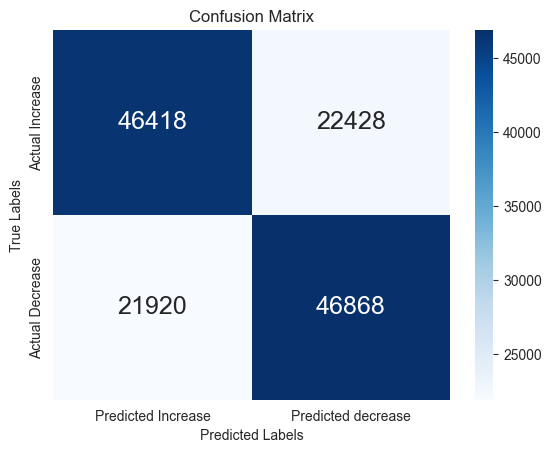

In [4]:
confusion_matrix = [[true_positives, false_positives], [false_negatives, true_negatives]]
# Convert to DataFrame for seaborn
confusion_df = pd.DataFrame(confusion_matrix, index=['Actual Increase', 'Actual Decrease'], columns=['Predicted Increase', 'Predicted decrease'])

# Plot confusion matrix heatmap
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues", annot_kws={'size': 18})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [5]:
print('total species: ', total_species, 'correct soecues: ', correct_species, 'uncertain: ', uncertain_species)

total species:  137634 correct soecues:  93286 uncertain:  2266


In [6]:
ratios = {}

for graph, r in pathways_results.items():
    
    list_ratios = []
    for exp in pathways_results[graph].values():
        list_ratios.append(exp['ratio'])
        
    ratios[graph] = list_ratios
    
ratios

{'18': [0.40540540540540543,
  0.5135135135135135,
  0.6486486486486487,
  0.5405405405405406,
  0.8648648648648649,
  0.5675675675675675,
  0.5675675675675675,
  0.7297297297297297,
  0.5945945945945946,
  0.6756756756756757,
  0.8108108108108109,
  0.6756756756756757,
  0.8108108108108109,
  0.7027027027027027,
  0.8108108108108109,
  0.6216216216216216,
  0.5675675675675675,
  0.7837837837837838,
  0.8648648648648649,
  0.7027027027027027,
  0.6486486486486487,
  0.6486486486486487,
  0.7567567567567568,
  0.7027027027027027,
  0.8108108108108109,
  0.7297297297297297,
  0.8918918918918919,
  0.6756756756756757,
  0.5405405405405406,
  0.6216216216216216,
  0.8378378378378378,
  0.6216216216216216,
  0.7567567567567568,
  0.5135135135135135,
  0.4864864864864865,
  0.6486486486486487,
  0.4594594594594595,
  0.7837837837837838,
  0.8648648648648649,
  0.6486486486486487,
  0.7027027027027027,
  0.6486486486486487,
  0.5945945945945946,
  0.6756756756756757,
  0.6486486486486487,
  0

/var/folders/rf/48x9qng97nl7d1b1_vbww4t80000gn/T/ipykernel_31238/288785003.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, vert=True)


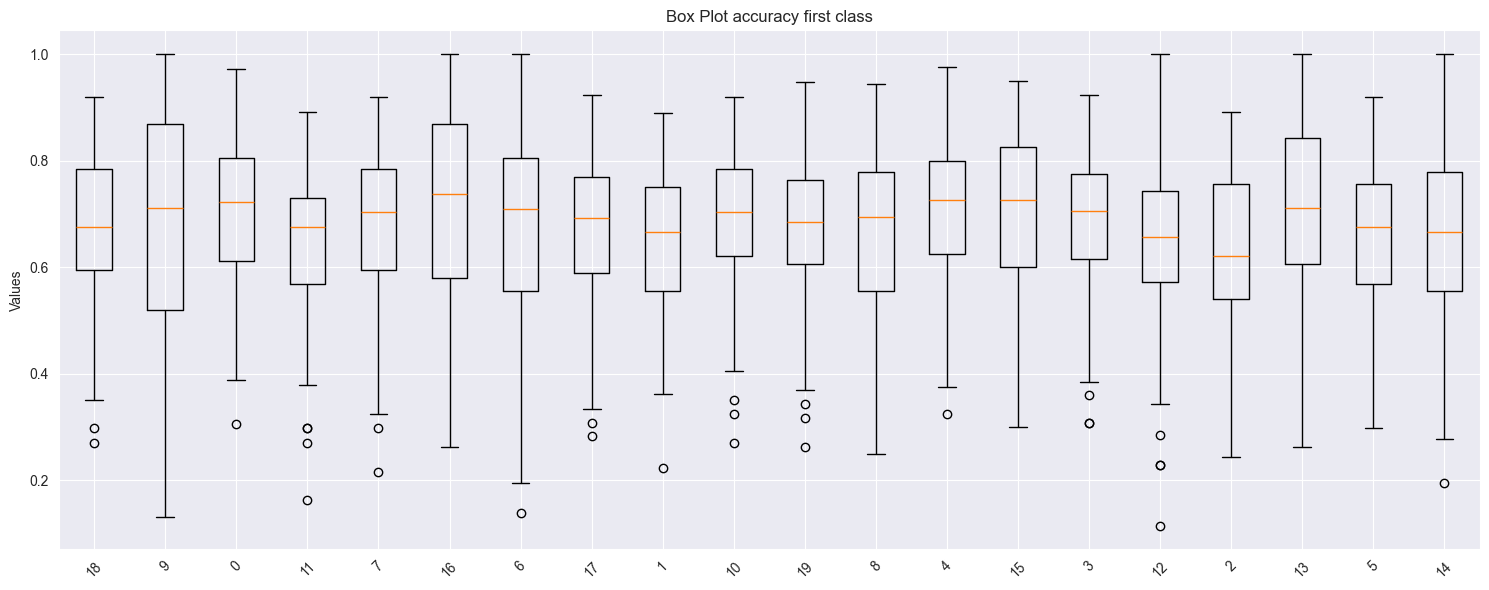

In [7]:
def plot_boxplots(data_dict):
    """
    Generate box plots for each key in the dictionary.

    Parameters:
    - data_dict (dict): A dictionary with keys as labels and values as lists or arrays of numbers.
    """
    labels = list(data_dict.keys())
    data = [data_dict[label] for label in labels]

    plt.figure(figsize=(15, 6))  # Adjust size depending on how readable you want it
    plt.boxplot(data, labels=labels, vert=True)
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.title("Box Plot accuracy first class")
    plt.ylabel("Values")
    plt.tight_layout()
    plt.show()

plot_boxplots(ratios)

In [9]:
def plot_boxplots(data_dict):
    """
    Generate box plots for each key in the dictionary.

    Parameters:
    - data_dict (dict): A dictionary with keys as labels and values as lists or arrays of numbers.
    """
    labels = list(data_dict.keys())
    data = [data_dict[label] for label in labels]

    plt.figure(figsize=(15, 6))  # Adjust size depending on how readable you want it
    plt.boxplot(data, labels=labels, vert=True)
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.title("Box Plot accuracy per pathway large class conserving")
    plt.ylabel("Ratio")
    plt.xlabel("Pathway #")
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.show()

In [8]:
for pw in pathways_results.keys():
    pw_path = os.path.join(base_path, pw)
    for exp in pathways_results[pw].keys():
        res_path = os.path.join(pw_path, exp, 'results')
        res_file = open(res_path, 'wb')
        pickle.dump(pathways_results[pw][exp], res_file)
        res_file.close()

## Retrieve results

In [10]:
res_pathways = defaultdict(lambda : [])
for pw in os.listdir(base_path):
    if pw == '.DS_Store' or pw == 'debug': continue
    res = defaultdict(lambda : {})
    pw_path = os.path.join(base_path, pw)
    for exp in os.listdir(pw_path):
        if exp == '.DS_Store': continue
        res_path = os.path.join(pw_path, exp, 'results')
        res_file = open(res_path, 'rb')
        r = pickle.load(res_file)
        res_file.close()
        res[exp] = r
    res_pathways[pw] = res

/var/folders/rf/48x9qng97nl7d1b1_vbww4t80000gn/T/ipykernel_31238/1324270400.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, vert=True)


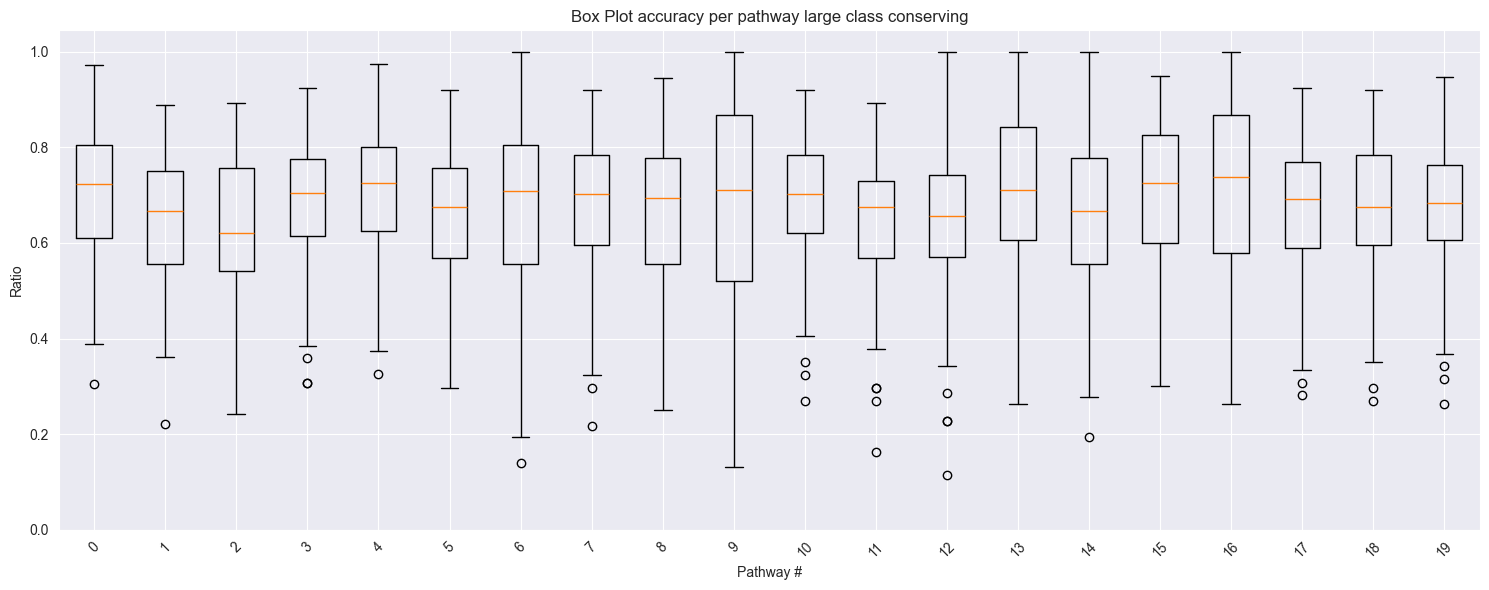

In [11]:
ratios = {}

for graph, r in res_pathways.items():
    
    list_ratios = []
    for exp in res_pathways[graph].values():
        list_ratios.append(exp['ratio'])
        
    ratios[graph] = list_ratios
    
sorted_ratios = dict(sorted(ratios.items(), key=lambda item: int(item[0])))
plot_boxplots(sorted_ratios)